In [6]:
%load_ext autoreload
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from enviornment import WumpusEnv

import random
import pygame, random, sys
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def state_to_tensor(state, H, W):
    """
    Encodes the state as a One-Hot Tensor.
    Instead of 1 number per cell, we use N channels per cell.

    Channels:
    0: Empty
    1: Pit
    2: Exit
    3: Gold
    4: Wumpus (Up)
    5: Wumpus (Down)
    6: Wumpus (Left)
    7: Wumpus (Right)
    8: Agent (No Gold)
    9: Agent (Have Gold)

    Total Input Size: H * W * 10
    """
    num_classes = 10
    # Shape: (10, H, W)
    grid = torch.zeros((num_classes, H, W), dtype=torch.float32)

    grid[0, :, :] = 1.0

    def set_cell(c, r, cat_idx):
        grid[0, r, c] = 0.0 
        grid[cat_idx, r, c] = 1.0 

    # 1. Pits
    for pr, pc in state["pits"]:
        set_cell(pc, pr, 1)

    # 2. Exit
    er, ec = state["exit"]
    set_cell(ec, er, 2)

    # 3. Gold
    if state["gold"] is not None:
        gr, gc = state["gold"]
        set_cell(gc, gr, 3)

    # 4-7. Wumpus
    face_map = {"up": 4, "down": 5, "left": 6, "right": 7}
    for i, pos in enumerate(state["wumpus"]):
        wr, wc = pos
        fac = state["wumpus_facing"].get(pos, "down")
        cat = face_map.get(fac, 5)
        set_cell(wc, wr, cat)

    # 8-9. Agent
    ar, ac = state["agent"]
    if state.get("have_gold", False):
        set_cell(ac, ar, 9)
    else:
        set_cell(ac, ar, 8)

    # Flatten to 1D vector: (10 * H * W)
    return grid.flatten()


class PolicyNet(nn.Module):
    def __init__(self, input_dim, hidden=128, n_actions=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, n_actions),
        )

    def forward(self, x):
        return self.net(x)


def run_episode(env, model, device=None):
    """
    Run one episode using the current stochastic policy.
    Returns: trajectory list[(state_tensor_cpu, action_int)], total_reward
    - Uses state_to_flat_grid_with_facing(state, H, W) as encoder.
    - Auto-detects device from model if device is None.
    """
    if device is None:
        device = next(model.parameters()).device

    traj = []
    state = env.get_state()
    done = state["done"]
    total = 0

    while not done:
        # encode state as flat H*W tensor (keeps wumpus facing)
        inp = state_to_tensor(state, env.h, env.w).to(device)  # (H*W,)
        EPSILON = 0.1
        
        if random.random() <= EPSILON:
            action = random.randrange(4)
        with torch.no_grad():
            logits = model(inp.unsqueeze(0))  # (1,4)
            probs = torch.softmax(logits, dim=-1).squeeze(0)  # (4,)
            action = torch.multinomial(probs, num_samples=1).item()

        reward, done = env.step(action)
        total += reward

        traj.append((inp.cpu(), action))  # store CPU tensor for batching later
        state = env.get_state()

    return traj, total

In [8]:
model = PolicyNet(10 * 8 * 8)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
epochs = 50
train_epochs = 100
batch_size = 320
elite_frac = 0.15

mean_rewards = []
best_rewards = []


env = WumpusEnv(w=8, h=8, n_pits=6, n_wumpus=3, seed=42, wumpus_orientation="down")

for epoch in range(epochs):
    # 1) Collect batch_size episodes using current policy
    episodes = []
    rewards = []

    for _ in range(batch_size):
        env.reset()
        traj, total = run_episode(env, model)
        episodes.append(traj)
        rewards.append(total)

    rewards = np.array(rewards)

    k = max(1, int(batch_size * elite_frac))
    elite_idx = rewards.argsort()[-k:]
    elite_trajs = [episodes[i] for i in elite_idx]

    states_list = []
    actions_list = []
    for traj in elite_trajs:
        for s, a in traj:
            states_list.append(s.numpy())
            actions_list.append(a)
    if len(states_list) == 0:
        print(f"Epoch {epoch}: no elite data, skipping")
        continue
    states = torch.tensor(np.stack(states_list), dtype=torch.float32)  # (N, input_dim)
    actions = torch.tensor(actions_list, dtype=torch.long)  # (N,)

    for i in range(train_epochs):
        opt.zero_grad()
        a_predict = model(states)  # (N, 4)
        loss = criterion(a_predict, actions)
        loss.backward()
        opt.step()

    mean_r = rewards.mean()
    best_r = rewards.max()
    
    mean_rewards.append(mean_r)
    best_rewards.append(best_r)
    print(f"Epoch {epoch:03d}  meanR {mean_r:.1f}  bestR {best_r:.1f}  elite_steps {len(states_list)}")
    torch.save(model.state_dict(), "./models/policy_nn.pt")

Epoch 000  meanR -293.6  bestR 388.0  elite_steps 266
Epoch 001  meanR -142.3  bestR 271.0  elite_steps 455
Epoch 002  meanR -94.5  bestR 283.0  elite_steps 1318
Epoch 003  meanR -29.2  bestR 434.0  elite_steps 729
Epoch 004  meanR 78.3  bestR 442.0  elite_steps 949
Epoch 005  meanR 327.8  bestR 442.0  elite_steps 751
Epoch 006  meanR 422.1  bestR 442.0  elite_steps 528
Epoch 007  meanR 437.7  bestR 442.0  elite_steps 528
Epoch 008  meanR 442.0  bestR 442.0  elite_steps 528
Epoch 009  meanR 442.0  bestR 442.0  elite_steps 528
Epoch 010  meanR 442.0  bestR 442.0  elite_steps 528
Epoch 011  meanR 442.0  bestR 442.0  elite_steps 528
Epoch 012  meanR 442.0  bestR 442.0  elite_steps 528
Epoch 013  meanR 442.0  bestR 442.0  elite_steps 528


KeyboardInterrupt: 

Text(0.5, 1.0, 'best rewards')

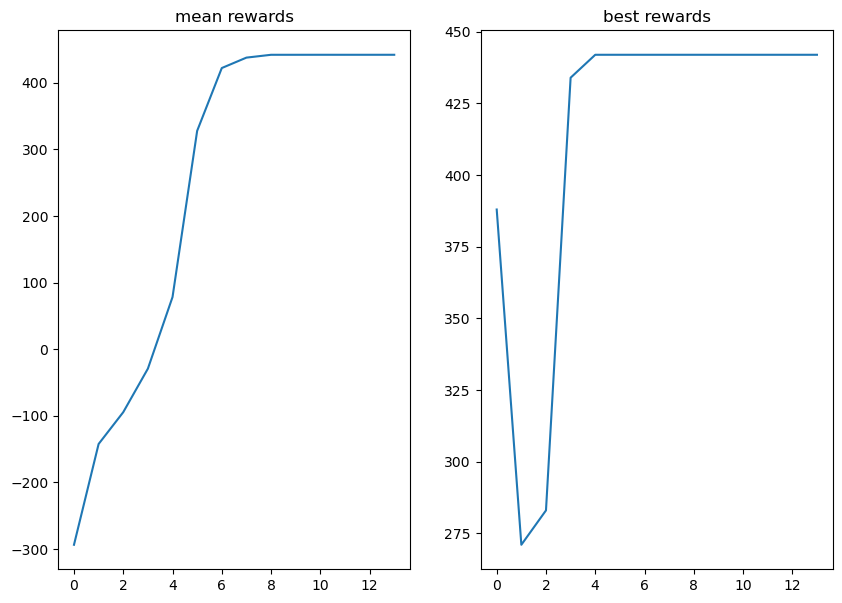

In [10]:
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(mean_rewards)
plt.title("mean rewards")

plt.subplot(122)
plt.plot(best_rewards)
plt.title("best rewards")

In [11]:
def pick_player():
    return random.choice(glob("images/player_images/*"))


wumpus_img = "images/wumpus.png"
pit_img = "images/pit.png"
gold_img = "images/gold.png"
exit_img = "images/exit.png"


def load_img(path, size):
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # BGR or BGRA
    if im is None:
        raise ValueError("cv2.imread returned None")
    h0, w0 = im.shape[:2]
    target_w, target_h = size
    scale = min(target_w / w0, target_h / h0)
    new_w, new_h = max(1, int(w0 * scale)), max(1, int(h0 * scale))
    im_resized = cv2.resize(im, (new_w, new_h), interpolation=cv2.INTER_AREA)

    im_rgba = cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGBA)

    canvas = np.zeros((target_h, target_w, 4), dtype=np.uint8)  # h x w x 4

    x = (target_w - new_w) // 2
    y = (target_h - new_h) // 2
    canvas[y : y + new_h, x : x + new_w] = im_rgba

    surf = pygame.image.frombuffer(canvas.tobytes(), (target_w, target_h), "RGBA")
    return surf


INPUT_DIM = 640
HIDDEN_DIM = 128
N_ACTIONS = 4


def main():
    import time

    model = PolicyNet(INPUT_DIM, hidden=HIDDEN_DIM, n_actions=N_ACTIONS)

    try:
        model.load_state_dict(torch.load("./models/policy_nn.pt"))
    except FileNotFoundError:
        print("Error: policy_nn.pt not found. Ensure the file exists.")
        return

    model.eval()

    pygame.init()
    CELL = 64
    ASSET_SIZE = (CELL - 8, CELL - 8)

    env = WumpusEnv(w=8, h=8, n_pits=6, n_wumpus=3, seed=42, wumpus_orientation="down")

    assets = {
        "wumpus": load_img(wumpus_img, ASSET_SIZE),
        "player": load_img(pick_player(), ASSET_SIZE),
        "pit": load_img(pit_img, ASSET_SIZE),
        "gold": load_img(gold_img, ASSET_SIZE),
        "exit": load_img(exit_img, ASSET_SIZE),
    }

    W, H = env.w * CELL, env.h * CELL + 40
    screen = pygame.display.set_mode((W, H))
    clock = pygame.time.Clock()

    env.reset() 
    env.render(screen, CELL, assets)
    pygame.display.flip()

    while True:
        for e in pygame.event.get():
            if e.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

            if e.type == pygame.KEYDOWN and e.key == pygame.K_r:
                env.reset()
                assets["player"] = load_img(pick_player(), ASSET_SIZE)
                env.render(screen, CELL, assets)
                pygame.display.flip()
                continue 

        if not env.done:
            # 1. Get current state and convert to tensor
            state = env.get_state()
            inp = state_to_tensor(state, env.h, env.w)

            # 2. Get the action from the model
            with torch.no_grad():
                logits = model(inp.unsqueeze(0))
                action_int = torch.argmax(logits, dim=-1).item()

            # 3. Step the environment
            reward, done = env.step(action_int)

            # 4. Render and Wait
            env.render(screen, CELL, assets)
            pygame.display.flip()

            # Slow down the AI's speed for visual demonstration
            time.sleep(0.1)

            # 5. Check if terminal state was reached
            if done:
                overlay = pygame.Surface((W, H), pygame.SRCALPHA)
                overlay.fill((0, 0, 0, 160))
                screen.blit(overlay, (0, 0))
                font = pygame.font.SysFont(None, 36)

                # Show final status and score
                status = "WON!" if env.total > 0 else "DIED!"
                msg = f"AI {status} Final Score: {env.total} (R to restart)"

                text = font.render(msg, True, (255, 255, 255))
                screen.blit(text, text.get_rect(center=(W // 2, H // 2)))
                pygame.display.flip()

        clock.tick(30)


if __name__ == "__main__":
    main()

SystemExit: 

c:\Users\zeyad\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
